In [1]:
pip install -U jax

In [2]:
import jax
import jax.numpy as jnp

import jax.lax as lax
import cupy as cp
import pandas as pd

import numpy as np

import platform
import cpuinfo

from jax import random
import time
import matplotlib.pyplot as plt

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.3 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


In [3]:

print("CPU:", platform.processor())
print("CPU info:", cpuinfo.get_cpu_info()['brand_raw'])


CPU: x86_64
CPU info: Intel(R) Xeon(R) CPU @ 2.20GHz


In [4]:



def gelu_np(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))

def lnorm_np(x, eps=1e-5):
    mean = np.mean(x, axis=0, keepdims=True)
    var = np.var(x, axis=0, keepdims=True)
    return (x - mean) / np.sqrt(var + eps)

def matmul_np(a,b) :
    a_i32= a.astype(np.int32)
    b_i32= b.astype(np.int32)
    c = a_i32 @ b_i32
    return np.clip(c, -128, 127).astype(np.int8)


def causal_mask_np(seq_len):
    return np.tril(np.ones((seq_len, seq_len), dtype=bool))

def softmax_np(x, mask=None, axis=-1):
    if mask is not None:
        x = np.where(mask, x, -1e9)
    x_max = np.max(x, axis=axis, keepdims=True)
    e_x = np.exp(x - x_max)
    return e_x / np.sum(e_x, axis=axis, keepdims=True)


def attention_per_head_decoder_np(K, Q, V, l_total, ddh, b, h):
    K = K.astype(np.int32)
    Q = Q.astype(np.int32)
    V = V.astype(np.int32)
    lb = l_total * b
    d = K.shape[0]
    E2 = np.zeros((d, lb), dtype=np.int32)
    mask = causal_mask_np(l_total)
    for j in range(b):
        for i in range(h):
            indJ = j * l_total
            indI2 = i * ddh

            K_slice = K[indI2:indI2+ddh, indJ:indJ+l_total].astype(np.int32)
            Q_slice = Q[indI2:indI2+ddh, indJ:indJ+l_total].astype(np.int32)
            V_slice = V[indI2:indI2+ddh, indJ:indJ+l_total].astype(np.int32)

            scores = K_slice.T @ Q_slice / np.sqrt(ddh)
            E1 = softmax_np(scores,mask=mask, axis=0)

            result = V_slice @ E1
            E2[indI2:indI2+ddh, indJ:indJ+l] = np.clip(result, -128, 127).astype(np.int8)

    return E2


def mha_output_np(WO, E2, EI):
    E2 = E2.astype(np.int32)
    WO = WO.astype(np.int32)
    EI = EI.astype(np.int32)
    AO = WO @ E2 + EI
    AO = lnorm_np(AO)
    return np.clip(AO, -128, 127).astype(np.int8)

def ffn_forward_np(W1, W2, AO):
    W1 = W1.astype(np.int32)
    W2 = W2.astype(np.int32)
    AO = AO.astype(np.int32)
    E3b = W1 @ AO
    E3 = gelu_np(E3b)
    EOb = W2 @ E3
    EO = lnorm_np(EOb + AO)
    return np.clip(EO, -128, 127).astype(np.int8)


In [5]:

def gelu_jax(x):
    return 0.5 * x * (1 + jnp.tanh(jnp.sqrt(2 / jnp.pi) * (x + 0.044715 * x**3)))


def lnorm_jax(x, eps=1e-5):
    mean = jnp.mean(x, axis=0, keepdims=True)
    var = jnp.var(x, axis=0, keepdims=True)
    return (x - mean) / jnp.sqrt(var + eps)


def causal_mask_jax(seq_len):
    return jnp.tril(jnp.ones((seq_len, seq_len), dtype=bool))


def softmax_jax(x, mask=None, axis=-1):
    if mask is not None:
        x = jnp.where(mask, x, -1e9)
    x_max = jnp.max(x, axis=axis, keepdims=True)
    e_x = jnp.exp(x - x_max)
    return e_x / jnp.sum(e_x, axis=axis, keepdims=True)


def matmul_jax(a, b):
    a_i32= a.astype(jnp.int32)
    b_i32= b.astype(jnp.int32)
    c = a_i32 @ b_i32
    return jnp.clip(c, -128, 127).astype(jnp.int8)


def attention_per_head_decoder_jax(K, Q, V, l_total, ddh, b, h):
    K= K.astype(jnp.int32)
    Q= Q.astype(jnp.int32)
    V= V.astype(jnp.int32)
    lb = l_total * b
    d = K.shape[0]
    E2_init = jnp.zeros((d, lb), dtype=jnp.int32)
    mask= causal_mask_jax(l_total)

    def process_single_head(E2, idx):
        j, i = idx // h, idx % h
        indJ = j * l_total
        indI2 = i * ddh

        K_slice = lax.dynamic_slice(K, (indI2, indJ), (ddh, l_total)).astype(jnp.int32)
        Q_slice = lax.dynamic_slice(Q, (indI2, indJ), (ddh, l_total)).astype(jnp.int32)
        V_slice = lax.dynamic_slice(V, (indI2, indJ), (ddh, l_total)).astype(jnp.int32)

        scores = K_slice.T @ Q_slice / jnp.sqrt(ddh)
        E1 = softmax_jax(scores,mask=mask, axis=0)

        result = V_slice @ E1
        result_int8 = jnp.clip(result, -128, 127).astype(jnp.int8)
        E2 = lax.dynamic_update_slice(E2, result_int8, (indI2, indJ))
        return E2, None
    E2_init = jnp.zeros((d, lb), dtype=jnp.int8)
    idxs = jnp.arange(b * h)
    E2, _ = lax.scan(process_single_head, E2_init, idxs)
    return E2


def mha_output_jax(WO, E2, EI):
    E2 = E2.astype(jnp.int32)
    EI = EI.astype(jnp.int32)
    WO = WO.astype(jnp.int32)
    AO = WO @ E2 + EI
    AO = lnorm_jax(AO)
    return jnp.clip(AO, -128, 127).astype(jnp.int8)


def ffn_forward_jax(W1, W2, AO):
    AO = AO.astype(jnp.int32)
    W1 = W1.astype(jnp.int32)
    W2 = W2.astype(jnp.int32)
    E3b = W1 @ AO
    E3 = gelu_jax(E3b)
    EOb = W2 @ E3
    EO = lnorm_jax(EOb + AO)
    return jnp.clip(EO, -128, 127).astype(jnp.int8)


b = 24
l = 128
d = 1024
h = 16


f = 4 * d
ddh = d // h
lb = b * l



In [6]:
# Generate random input data

key = jax.random.PRNGKey(0)
keys = jax.random.split(key, 7)


# Generate int values in range [-128,127]
EI_jax = jax.random.randint(keys[0], (d, lb), minval=-128, maxval=128, dtype=jnp.int8)
WQ = jax.random.randint(keys[1], (d, d), minval=-128, maxval=128, dtype=jnp.int8)
WK = jax.random.randint(keys[2], (d, d), minval=-128, maxval=128, dtype=jnp.int8)
WV = jax.random.randint(keys[3], (d, d), minval=-128, maxval=128, dtype=jnp.int8)
WO = jax.random.randint(keys[4], (d, d), minval=-128, maxval=128, dtype=jnp.int8)
W1 = jax.random.randint(keys[5], (f, d), minval=-128, maxval=128, dtype=jnp.int8)
W2 = jax.random.randint(keys[6], (d, f), minval=-128, maxval=128, dtype=jnp.int8)


# Convert to numpy
EI_np, WQ_np, WK_np, WV_np, WO_np, W1_np, W2_np = map(np.array, [EI_jax ,WQ, WK, WV, WO, W1, W2])


In [7]:
# NumPy

results={}
results["NumPy"] = {}

# warmup
Qc = matmul_np(WQ_np, EI_np)

start = time.time()
Qc = matmul_np(WQ_np, EI_np)

end = time.time()
results["NumPy"]["matmul_Q"] = end - start

start = time.time()
Kc = matmul_np(WK_np, EI_np)

end = time.time()
results["NumPy"]["matmul_K"] = end - start

start = time.time()
Vc = matmul_np(WV_np, EI_np)

end = time.time()
results["NumPy"]["matmul_V"] = end - start

start = time.time()
E2n = attention_per_head_decoder_np(Kc, Qc, Vc, l, ddh, b, h)

end = time.time()
results["NumPy"]["attention"] = end - start

start = time.time()
AOc = mha_output_np(WO_np, E2n, EI_np)

end = time.time()
results["NumPy"]["mha_output"] = end - start

start = time.time()
EOc = ffn_forward_np(W1_np, W2_np, AOc)

end = time.time()
results["NumPy"]["ffn"] = end - start

results["NumPy"]["total"] = sum(results["NumPy"].values())
print(results["NumPy"])

{'matmul_Q': 17.780769109725952, 'matmul_K': 15.841110229492188, 'matmul_V': 16.22145175933838, 'attention': 1.1004154682159424, 'mha_output': 15.867189645767212, 'ffn': 74.5051863193512, 'total': 141.31612253189087}


In [8]:

# JAX sin JIT
results["JAX"] = {}

# warmup
Qj = matmul_jax(WQ,  EI_jax).block_until_ready()


start = time.time()
Qj = matmul_jax(WQ,  EI_jax).block_until_ready()
end = time.time()
results["JAX"]["matmul_Q"] = end - start

start = time.time()
Kj = matmul_jax(WK,  EI_jax).block_until_ready()
end = time.time()
results["JAX"]["matmul_K"] = end - start

start = time.time()
Vj = matmul_jax(WV,  EI_jax).block_until_ready()
end = time.time()
results["JAX"]["matmul_V"] = end - start

start = time.time()
E2j = attention_per_head_decoder_jax(Kj, Qj, Vj, l, ddh, b, h).block_until_ready()
end = time.time()
results["JAX"]["attention"] = end - start

start = time.time()
AOj = mha_output_jax(WO, E2j, EI_jax).block_until_ready()
end = time.time()
results["JAX"]["mha_output"] = end - start

start = time.time()
EOj = ffn_forward_jax(W1, W2, AOj).block_until_ready()
end = time.time()
results["JAX"]["ffn"] = end - start

results["JAX"]["total"] = sum(results["JAX"].values())

print(results["JAX"])


{'matmul_Q': 0.6952958106994629, 'matmul_K': 0.6819126605987549, 'matmul_V': 0.664771556854248, 'attention': 0.9325821399688721, 'mha_output': 0.8574342727661133, 'ffn': 3.18906307220459, 'total': 7.021059513092041}


In [9]:
results["JIT-COMP"] = {}

# JIT

matmul_jit= jax.jit(matmul_jax)
attention_per_head_jit = jax.jit(attention_per_head_decoder_jax, static_argnums=(3, 4, 5, 6))
mha_output_jit = jax.jit(mha_output_jax)
ffn_forward_jit = jax.jit(ffn_forward_jax)



start = time.time()
Qj = matmul_jit(WQ,  EI_jax).block_until_ready()
end = time.time()
results["JIT-COMP"]["matmul_Q"] = end - start

start = time.time()
Kj = matmul_jit(WK,  EI_jax).block_until_ready()
end = time.time()
results["JIT-COMP"]["matmul_K"] = end - start

start = time.time()

Vj = matmul_jit(WV,  EI_jax).block_until_ready()
end = time.time()
results["JIT-COMP"]["matmul_V"] = end - start


start_attention=  time.time()

E2j = attention_per_head_jit(Kj, Qj, Vj, l, ddh, b, h).block_until_ready()
end_attention = time.time()
t = end_attention - start_attention
results["JIT-COMP"]["attention"] = t


start_mha_output=  time.time()
AOj = mha_output_jit(WO, E2j, EI_jax).block_until_ready()
end_mha_output = time.time()
t= end_mha_output - start_mha_output
results["JIT-COMP"]["mha_output"] = t

start_ffn=time.time()
FFj = ffn_forward_jit(W1, W2, AOj).block_until_ready()
end_ffn = time.time()
t = end_ffn - start_ffn

results["JIT-COMP"]["ffn"] = t

results["JIT-COMP"]["total"] = sum(results["JIT-COMP"].values())



In [10]:
print(results["JIT-COMP"])

{'matmul_Q': 0.5242455005645752, 'matmul_K': 0.43053650856018066, 'matmul_V': 0.4496884346008301, 'attention': 0.5324475765228271, 'mha_output': 0.6401655673980713, 'ffn': 2.4352834224700928, 'total': 5.012367010116577}


In [11]:
# JAX with JIT

results["JAX-JIT"] = {}
Qj = matmul_jit(WQ,  EI_jax).block_until_ready()
start = time.time()
Qj = matmul_jit(WQ,  EI_jax).block_until_ready()
end = time.time()
results["JAX-JIT"]["matmul_Q"] = end - start

start = time.time()
Kj = matmul_jit(WK,  EI_jax).block_until_ready()
end = time.time()
results["JAX-JIT"]["matmul_K"] = end - start

start = time.time()
Vj = matmul_jit(WV,  EI_jax).block_until_ready()
end = time.time()
results["JAX-JIT"]["matmul_V"] = end - start


start_attention=  time.time()

E2j = attention_per_head_jit(Kj, Qj, Vj, l, ddh, b, h).block_until_ready()
end_attention = time.time()
t = end_attention - start_attention
results["JAX-JIT"]["attention"] = t


start_mha_output=  time.time()
AOj = mha_output_jit(WO, E2j, EI_jax).block_until_ready()
end_mha_output = time.time()
t= end_mha_output - start_mha_output
results["JAX-JIT"]["mha_output"] = t


start_ffn=time.time()
FFj = ffn_forward_jit(W1, W2, AOj).block_until_ready()
end_ffn = time.time()
t = end_ffn - start_ffn
results["JAX-JIT"]["ffn"] = t

results["JAX-JIT"]["total"] = sum(results["JAX-JIT"].values())

In [12]:
print(results["JAX-JIT"])

{'matmul_Q': 0.5197820663452148, 'matmul_K': 0.6142067909240723, 'matmul_V': 0.6708774566650391, 'attention': 0.32906627655029297, 'mha_output': 0.6862785816192627, 'ffn': 2.408836841583252, 'total': 5.229048013687134}


In [13]:
print(results.keys())


dict_keys(['NumPy', 'JAX', 'JIT-COMP', 'JAX-JIT'])


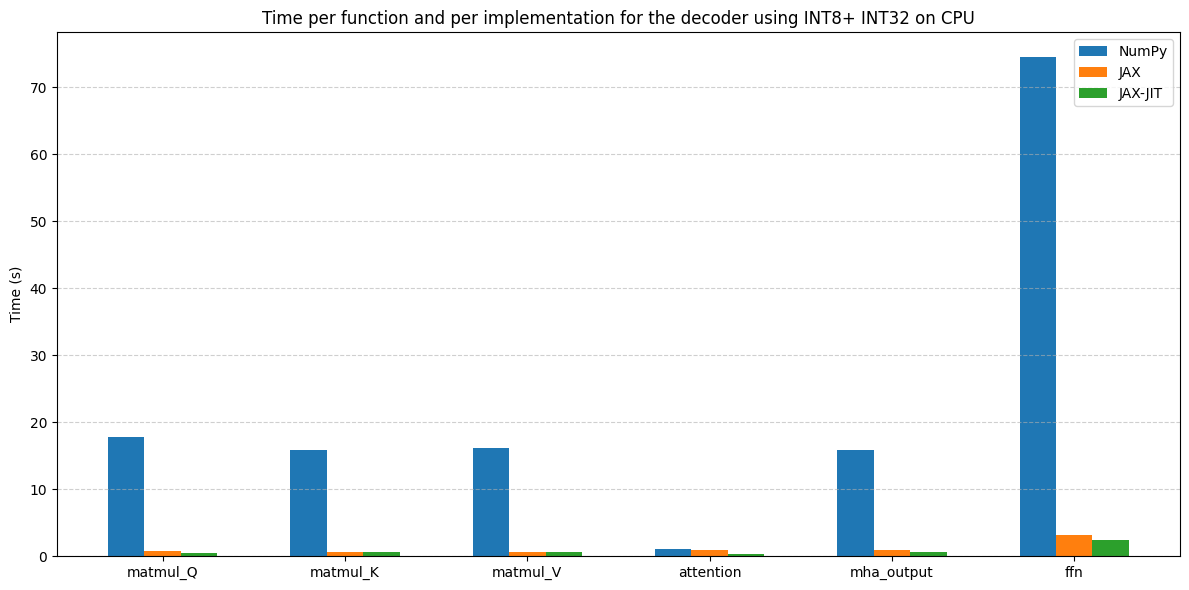

In [14]:



labels = ["matmul_Q","matmul_K","matmul_V", "attention", "mha_output", "ffn"]
x = np.arange(len(labels))
width = 0.20

fig, ax = plt.subplots(figsize=(12, 6))


ax.bar(x - 1*width, [results["NumPy"][l] for l in labels], width, label='NumPy')
ax.bar(x - 0*width, [results["JAX"][l] for l in labels], width, label='JAX')
#ax.bar(x + 0.5*width, [results["JIT-COMP"][l] for l in labels], width, label='JIT-COMP')
ax.bar(x + 1*width, [results["JAX-JIT"][l] for l in labels], width, label='JAX-JIT')

ax.set_ylabel('Time (s)')
ax.set_title('Time per function and per implementation for the decoder using INT8+ INT32 on CPU')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()


plt.show()

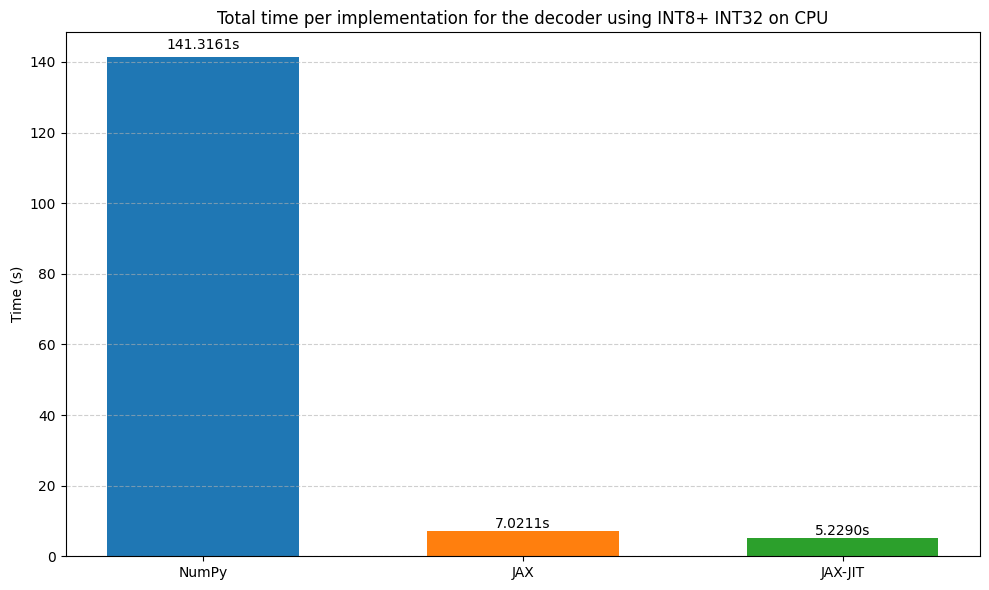

In [15]:

labels = ["NumPy", "JAX","JAX-JIT"]
x = np.arange(len(labels))
width = 0.6

fig, ax = plt.subplots(figsize=(10, 6))


ax.bar(x, [results[l]["total"] for l in labels], width, label='Total Time',
       color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])


for i, label in enumerate(labels):
    height = results[label]["total"]
    ax.text(i, height + 0.01 * height, f'{height:.4f}s',
            ha='center', va='bottom')

ax.set_ylabel('Time (s)')
ax.set_title('Total time per implementation for the decoder using INT8+ INT32 on CPU')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()


plt.show()

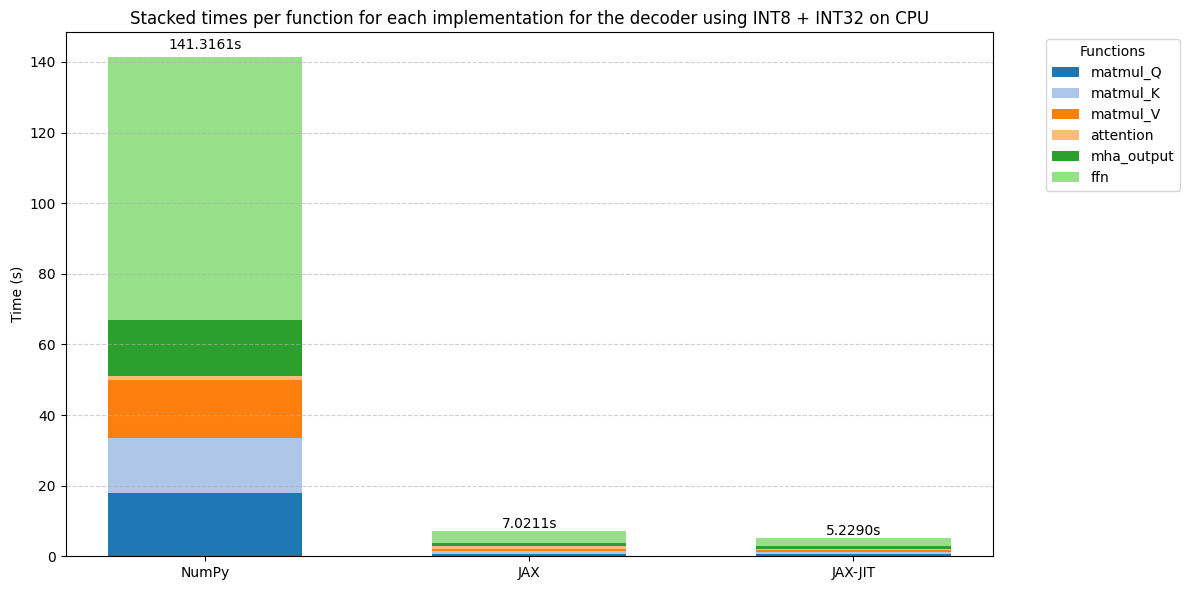

In [16]:

implementations = ["NumPy", "JAX", "JAX-JIT"]
functions = ["matmul_Q", "matmul_K", "matmul_V", "attention", "mha_output", "ffn"]
colors = plt.get_cmap("tab20").colors

x = np.arange(len(implementations))
width = 0.6

fig, ax = plt.subplots(figsize=(12, 6))


bottom = np.zeros(len(implementations))


for i, func in enumerate(functions):
    values = [results[impl][func] for impl in implementations]
    ax.bar(x, values, width, label=func, bottom=bottom, color=colors[i])
    bottom += values

for i, impl in enumerate(implementations):
    total = sum(results[impl][func] for func in functions)
    ax.text(i, total + 0.01 * total, f'{total:.4f}s', ha='center', va='bottom')


ax.set_ylabel('Time (s)')
ax.set_title('Stacked times per function for each implementation for the decoder using INT8 + INT32 on CPU')
ax.set_xticks(x)
ax.set_xticklabels(implementations)

ax.legend(title="Functions", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()


In [17]:
df = pd.DataFrame(results).T

In [18]:
cols_orden = ["matmul_Q", "matmul_K", "matmul_V", "attention", "mha_output", "ffn", "total"]
df = df[cols_orden]

In [19]:

display(df.style.format("{:.4f}").set_caption("Time per function and implementation for the decoder using INT8 + INT 32 on CPU"))



,matmul_Q,matmul_K,matmul_V,attention,mha_output,ffn,total
NumPy,17.7808,15.8411,16.2215,1.1004,15.8672,74.5052,141.3161
JAX,0.6953,0.6819,0.6648,0.9326,0.8574,3.1891,7.0211
JIT-COMP,0.5242,0.4305,0.4497,0.5324,0.6402,2.4353,5.0124
JAX-JIT,0.5198,0.6142,0.6709,0.3291,0.6863,2.4088,5.2290
